# DOCKSTRING figures

## Table of Contents
- [Parity plots](#parity-plots)
- [Bar charts](#bar-charts)
- [CSVs](#csvs)
- [Histograms](#histograms)

**NOTE:** This notebook requires you to have previously run the `process.py` and `collate.py` scripts mentioned in the README

In [18]:
from pathlib import Path
import pickle
import sys
from typing import List

import matplotlib as mpl
from matplotlib import container, pyplot as plt, patheffects as pe
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind_from_stats
from sklearn.metrics import r2_score

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment

sns.set_theme("talk", "white")

DOCKSTRING_PROCESSED_ROOT = Path.home() / "active-projects/molpal-pruning/processed/dockstring"
DOCKSTRING_RUNS_ROOT = Path.home() / "active-projects/molpal-pruning/runs/dockstring"
SIZE = int(260e3)

## Parity plots

[back to top](#table-of-contents)

In [2]:
def make_parity_plot(npy_file, N):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7.))

    ax.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'k--', zorder=0)

    Y = np.load(npy_file)[..., 2]
    Y_f = Y[0]
    Y_p = Y[1]
    _, P = ttest_ind_from_stats(
        Y_p.mean(1), Y_p.std(1), Y_p.shape[1],
        Y_f.mean(1), Y_f.std(1), Y_f.shape[1],
        True,
        "less"
    )
    
    bounds = [0.05]
    cmap = plt.cm.get_cmap("RdPu")
    norm = mpl.colors.BoundaryNorm([0] + bounds + [1], cmap.N)
    
    ax.scatter(
        Y_f.mean(1),
        Y_p.mean(1),
        c=cmap(norm(P*len(P))),
        vmin=0,
        vmax=0.1,
        edgecolors='k',
        zorder=2,
    )

    random = float(split) * N
    ax.scatter(random, random, marker="X", c='grey', edgecolors='k')
    ax.annotate(
        "random\nsearch", (random+0.01, random),
        xytext=(0.2, random+0.05), size="small", ha="center", va="center",
        arrowprops=dict(facecolor='black', shrink=0.05),)

    R2 = r2_score(Y_f.mean(1), Y_p.mean(1))
    ax.text(
        0.2, 0.8, rf"$R^2={R2:0.3f}$",
        va="center", ha="center", bbox=dict(facecolor='w', edgecolor='k', boxstyle='round')
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, ls="--")
    ax.set_xlabel(f"Fraction of Top-250 Scores Found (baseline)")
    ax.set_ylabel(f"Fraction of Top-250 Scores Found (DSP)")

    # cbar = fig.colorbar(
    #     plt.cm.ScalarMappable(norm, cmap),
    #     extend="both",
    #     fraction=0.05,
    #     aspect=30,
    #     label=r"MHC-adjusted $p$-value"
    # )
    # cbar.ax.set_yticks(bounds, labels=bounds)

    fig.tight_layout()
    
    return fig

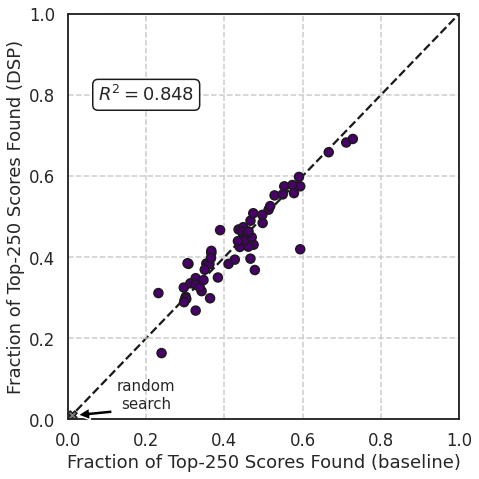

In [3]:
split = "0.001"
N = 10
fig = make_parity_plot(DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-Y.npy", N)
fig.savefig(f"../figures/dockstring-parity-{split}-{N}.pdf", dpi=400)

## Bar charts

[back to top](#table-of-contents)

In [38]:
def make_bar_chart(npy_file, targets_pkl, split: float, N):
    WIDTH = 0.75

    fig, ax = plt.subplots(1, 1, figsize=(6, 20))

    Y = np.load(npy_file)[..., 2]
    targets = pickle.load(open(targets_pkl, "rb"))
    Y_f = Y[0]
    Y_p = Y[1]
    x = np.arange(len(targets))

    idxs = np.argsort(Y_p.mean(1))
    Y_f = Y_f[idxs]
    Y_p = Y_p[idxs]
    targets = [targets[i] for i in idxs]

    _, P = ttest_ind_from_stats(
        Y_p.mean(1), Y_p.std(1), Y_p.shape[1],
        Y_f.mean(1), Y_f.std(1), Y_f.shape[1],
        True,
        "less"
    )
    P *= len(P) # bonferoni MHC correction
    
    bars = ax.barh(
        x, Y_f.mean(1) - Y_p.mean(1), WIDTH, left=Y_p.mean(1),
        color="white", ec='k', lw=2, hatch="//"
    )
    ax.barh(x, Y_p.mean(1), WIDTH, ec='k', lw=2)
    
    ax.bar_label(
        bars,
        [r"$\ast$" if p < 0.05 else "" for p in P],
        label_type="edge",
        padding=6,
        fontsize=12
    )
    
    ax.axvline(float(split)*(N+1), c="w", lw=1.5, dashes=(4, 3),)
    ax.grid(axis="x", ls="--")

    ax.set_xlim(0, 1)
    ax.set_ylim(-WIDTH, x[-1]+WIDTH)

    ax.set_yticks(x, labels=[target.upper() for target in targets], fontsize=12)

    ax.set_xlabel(f"Fraction of Top-250 Scores Found", fontsize=16)
    ax.tick_params(axis="x", labelsize=14)
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
    fig.tight_layout()

    return fig

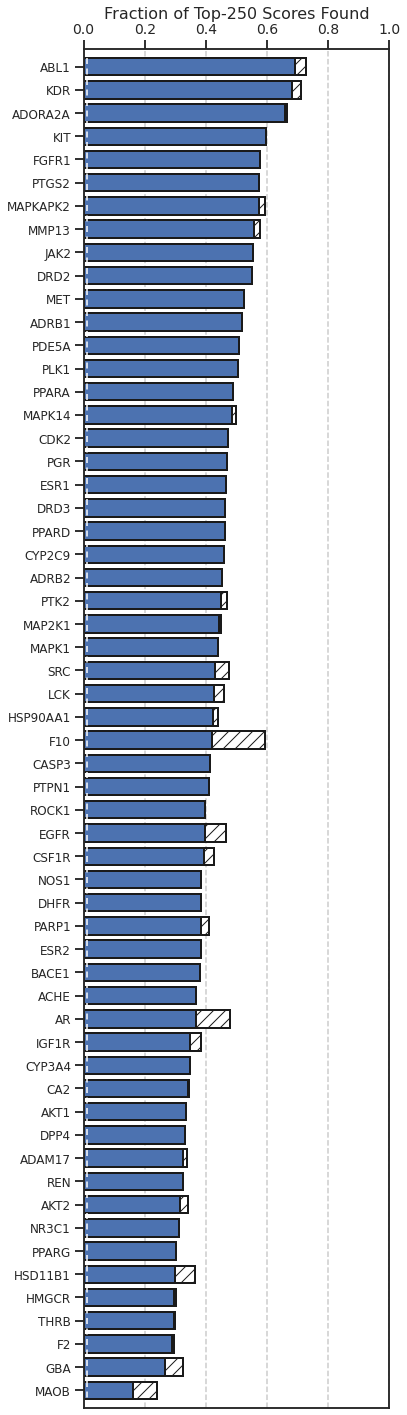

In [41]:
sns.set_style("ticks")

split = "0.001"
fig = make_bar_chart(
    DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-Y.npy",
    DOCKSTRING_PROCESSED_ROOT / f"collated-{split}-targets.pkl",
    float(split),
    10
)
fig.savefig(f"../figures/dockstring-bar-new-{split[2:]}.pdf", bbox_inches="tight")

## Histograms

```
DOCKSTRING_RUNS_ROOT
├── 0.001
│   ├── prune
│   │   ├── abl1
│   │   │   ├── rep-0 <-- output directory of a MolPAL run
│   │   │  ...
│   │   │   └── rep-N
│   │  ...
│   │   └── thrb
│   └── full
│       ├── abl1
│      ...
│       └── thrb
├── 0.002
|   ├── prune
│   └── full
└── 0.004
```

/home/degraff/molpal/notebooks/../scripts/experiment.py:38: UserWarning: Experiment has no score csvs!
  warnings.warn("Experiment has no score csvs!")
/home/degraff/molpal/notebooks/../scripts/experiment.py:38: UserWarning: Experiment has no score csvs!
  warnings.warn("Experiment has no score csvs!")
/home/degraff/molpal/notebooks/../scripts/experiment.py:38: UserWarning: Experiment has no score csvs!
  warnings.warn("Experiment has no score csvs!")


Text(0.5, 0, 'Fraction of inference calls')

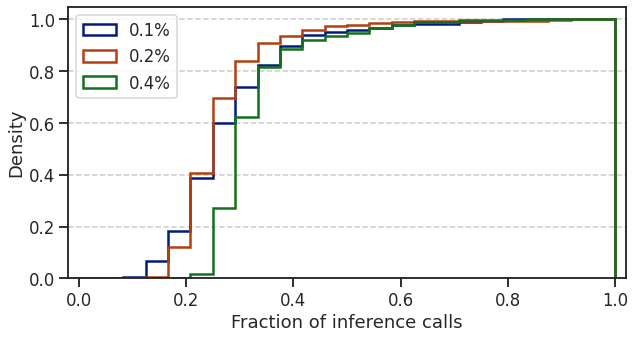

In [63]:
def retained_idxss(expt: Experiment) -> List[np.ndarray]:
    return [np.load(chkpt / "retained_idxs.npy") for chkpt in expt.chkpts[:-1]]

def pad_xss(xss) -> np.ndarray:
    n = max(len(xs) for xs in xss)
    xss = [np.pad(xs, (0, n - len(xs)), constant_values=np.nan) for xs in xss]

    return np.array(xss, float)

def total_inference_calls(split: str, N: int):
    target_dirs = sorted(
        (DOCKSTRING_RUNS_ROOT / split / "prune").iterdir(), key=lambda p: p.stem
    )
    N_calls = []
    for target_dir in target_dirs:
        n_calls = []
        for expt in target_dir.iterdir():
            expt = Experiment(expt)
            inf_calls = [SIZE, *[float(len(I)) for I in retained_idxss(expt)[:N-1]]]
            n_calls.append(sum(inf_calls))
        N_calls.append(n_calls)

    return pad_xss(N_calls)

sns.set_palette("dark")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

split = "0.004"
N = 5

for split, N in zip(["0.001", "0.002", "0.004"], [10, 8, 5]):
    N_calls = total_inference_calls(split, N)
    F_calls = N_calls[~np.isnan(N_calls)] / (SIZE * N)

    x, y, _ = ax.hist(
        F_calls, np.linspace(0, 1, 25), lw=2.5, density=True, cumulative=True, histtype="step",
        label=f"{float(split):0.1%}"
    )

ax.legend(loc="upper left")
ax.set_xlim(-0.02, 1.02)
ax.tick_params(axis="x", which="major", bottom=True)
ax.grid(True, which="both", axis="y", ls="--")

ax.set_ylabel("Density")
ax.set_xlabel("Fraction of inference calls")

In [64]:
fig.savefig("../figures/dockstring-calls-hist.pdf", bbox_inches="tight")

## CSVs

[back to top](#table-of-contents)

In [362]:
def make_dataframe(npy_file, targets_pkl, N) -> pd.DataFrame:
    Y = np.load(npy_file)[..., 2]
    targets = pickle.load(open(targets_pkl, "rb"))
    Y_f = Y[0]
    Y_p = Y[1]
    
    N_calls = total_inference_calls(split, N)
    df = pd.DataFrame(
        {
            "target": [t.upper() for t in targets],
            "no pruning (mean)": Y_f.mean(1),
            "no pruning (s.d.)": Y_f.std(1),
            "pruning (mean)": Y_p.mean(1),
            "pruning (s.d.)": Y_p.std(1),
            # "total inference calls (mean)": np.nanmean(N_calls, 1),
            # "total inference calls (s.d.)": np.nanstd(N_calls, 1)
        },
    )

    return df

In [67]:
split = "0.001"
N = 10

df = make_dataframe(split, N)
df["total inference calls (mean)"] = df["total inference calls (mean)"].map(lambda x: f"{x:0.1f}") 

df.to_csv(f"../csv/dockstring-perf+calls-{split[2:]}-{N}.csv", index=False, float_format="%.3f")
df

/home/degraff/molpal/notebooks/../scripts/experiment.py:38: UserWarning: Experiment has no score csvs!
  warnings.warn("Experiment has no score csvs!")


,target,no pruning (mean),no pruning (s.d.),pruning (mean),pruning (s.d.),total inference calls (mean),total inference calls (s.d.)
0,ABL1,0.728000,0.042029,0.691200,0.026095,603342.0,79266.140993
1,ACHE,0.350400,0.035291,0.380000,0.032332,889410.3,129971.207741
2,ADAM17,0.360667,0.111509,0.325600,0.065414,683433.6,77867.722991
3,ADORA2A,0.666400,0.014881,0.658400,0.007419,408528.0,71887.682803
4,ADRB1,0.512800,0.012750,0.516800,0.015471,803313.4,109917.340169
5,ADRB2,0.448000,0.035236,0.452800,0.021967,656114.0,68012.706816
6,AKT1,0.312800,0.062962,0.335200,0.032732,977610.8,193407.822052
7,AKT2,0.341600,0.023813,0.316000,0.018417,583985.4,141528.013040
8,AR,0.477600,0.023542,0.368000,0.129417,1023088.0,224353.507476
9,BACE1,0.361600,0.030526,0.382400,0.057778,639622.2,156723.646672


## Miscellaneous

In [ ]:
def make_prune_example(
    seed: int = 0, hit_cutoff: float = 1.0, prune_cutoff: float = 0., prob: bool = False
):
    np.random.seed(seed)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params("y", direction="inout", left="on")

    ax.set_ylabel(r"$\hat{y}$")
    ax.set_xlabel("Candidates")

    x = np.linspace(0, 1, 6)
    y_pred = np.random.normal(0, 2, size=len(x))
    y_sd = np.random.uniform(2, 2.5, size=len(x))

    ax.scatter(
        x, y_pred, c=y_pred, cmap="RdBu_r", edgecolors="k", linewidths=1.0, zorder=10
    )
    if not prob:
        ax.errorbar(x, y_pred, y_sd, capsize=3, capthick=2., ls="None", c="grey")
    else:
        data = [np.random.normal(m, sd, 10000) for m, sd in zip(y_pred, y_sd)]
        violin = ax.violinplot(
            data,
            x,
            True,
            widths=0.1,
            showmeans=False,
            showextrema=False,
            showmedians=False,
        )
        for pc in violin["bodies"]:
            pc.set_facecolor("m")
            pc.set_edgecolor("k")

    # hit_cutoff = 1.425
    ax.axhline(hit_cutoff, linestyle="--", c="r")
    ax.annotate(
        "predicted hit\nthreshold",
        xy=(0.52, hit_cutoff),
        xytext=(0.59, hit_cutoff + 3.75),
        arrowprops=dict(facecolor="black", shrink=0.05),
        wrap=True
    )

    if not prob:
        ax.axhline(prune_cutoff, linestyle="--", c="b")
        ax.annotate(
            "prune cutoff",
            xy=(0.8, prune_cutoff),
            xytext=(0.75, prune_cutoff+1.5),
            arrowprops=dict(facecolor="black", shrink=0.05),
            horizontalalignment="center",
            verticalalignment="bottom",
        )
        
    return fig


In [ ]:
make_prune_example(6, 3, prob=True).savefig("../figures/pruning/prune-prob-ex.pdf")